In [1]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import my_wise_utility_v2 as my_wise_ut
import astropy.io.fits as pf
import warnings
from astropy.table import Table, vstack
from desi_retriever.blanc import get_specs
import scipy.ndimage as sn
warnings.filterwarnings('ignore')

In [2]:
def deltachi2_limit_maximize(catalog,log_deltach2_bin,total_good_number):
    
    fraction = []
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(catalog)
    good_fraction = []
    for i in range(0,len(log_deltach2_bin['average_bin'])):
        search = np.where(np.log10(catalog['DELTACHI2_cas'])>=log_deltach2_bin['bin'][i])
        good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(catalog[search[0]])
        
        fraction.append(len(good_catalog)*1.0/len(search[0]))
        good_fraction.append(len(good_catalog)*1.0/total_good_number)
    return log_deltach2_bin['bin'][0:-1],fraction,good_fraction

In [3]:
def sub_sample_based_on_depth(data,depth_min, depth_max):
    return data[(data['R_DEPTH_EBVAIR']>=depth_min) & (data['R_DEPTH_EBVAIR']<depth_max)]

In [4]:
def good_robust_redrock_redshift(data):
    dz = abs(data['Z']-data['best_z'])/(1.+data['best_z'])
    search = np.where((dz<=0.0033) & (data['best_quality']>=2.5) & (data['dz_subset']<0.0033))
    search_bad = np.where((dz>0.0033) | (data['best_quality']<2.5) | (data['dz_subset']>0.0033))
    search_bad_1 = np.where((dz>0.0033) & (data['best_quality']>=2.5))
    search_bad_2 = np.where((dz<0.0033) & (data['best_quality']<2.5))
    return data[search[0]],data[search_bad[0]],data[search_bad_1[0]],data[search_bad_2[0]]

In [5]:
def flux_to_mag(catalog):
    g = -2.5*np.log10(catalog['FIBERFLUX_G'])+22.5-3.214*catalog['EBV']
    r = -2.5*np.log10(catalog['FIBERFLUX_R'])+22.5-2.165*catalog['EBV']
    z = -2.5*np.log10(catalog['FIBERFLUX_Z'])+22.5-1.211*catalog['EBV']
    gr_color = g-r
    rz_color = r-z
    coii = gr_color + 1.2*rz_color
    return {'g':g,'r':r,'z':z,'gr':gr_color,'rz':rz_color,'coii':coii}

In [6]:
def calculate_rate(SV_depth_catalog,SV_depth_catalog_cut):
    Total_number = len(SV_depth_catalog)
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog)
    Total_good_number = len(good_catalog)

    Total_cut_number = len(SV_depth_catalog_cut)
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog_cut)

    Redshift_success_rate = len(good_catalog)*1.0/Total_cut_number
    Good_data_completeness = len(good_catalog)*1.0/Total_good_number

    print('Redshift success rate:', Redshift_success_rate)
    print('Good data completeness:', Good_data_completeness)
    print('Combined value:',Redshift_success_rate*Good_data_completeness)
    #print('Bad_1 to total Bad fraction:'. len(bad_1)/len())

In [7]:
def plot_fraction_good(good_catalog, SV_depth_catalog,log_delta_bin):
    x_all = np.log10(SV_depth_catalog['DELTACHI2_cas'])
    x_good = np.log10(good_catalog['DELTACHI2_cas'])
    total_good = len(x_good)
    all_number = []
    good_number = []
    for i_bin in range(0,len(log_delta_bin['average_bin'])):
        search = np.where((x_all>=log_delta_bin['bin'][i_bin]) & (x_all<log_delta_bin['bin'][i_bin+1]))
        all_number.append(len(search[0]))

        search = np.where((x_good>=log_delta_bin['bin'][i_bin]) & (x_good<log_delta_bin['bin'][i_bin+1]))
        good_number.append(len(search[0]))

    print(all_number)
    print(good_number)

    plt.axhline(0.985,ls='--')
    plt.plot(log_delta_bin['average_bin'],np.array(good_number)*1.0/all_number)
    for i_bin in range(0,len(log_delta_bin['average_bin'])):
        plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.08,str(all_number[i_bin]))
        plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.04,str(good_number[i_bin]))

    plt.ylim(-0.1,1.1)
    plt.xlim(0.5,3.1)

In [8]:
def plot_ELG_cc_plot(catalog):
    mag_info = flux_to_mag(catalog)
    
    plt.subplot(2,2,1)
    plt.scatter(mag_info['rz'],mag_info['gr'],s=1)
    plt.xlim(-2,2)
    plt.ylim(-1.5,1)
    plt.xlabel('r-z')
    plt.ylabel('g-r')
    
    plt.subplot(2,2,2)
    plt.scatter(mag_info['z'],mag_info['gr'],s=1)
    plt.xlim(19,24.5)
    plt.ylim(-1.5,1)
    plt.xlabel('z')
    plt.ylabel('gr')
    
    plt.subplot(2,2,3)
    plt.scatter(mag_info['z'],mag_info['rz'],s=1)
    plt.xlabel('z')
    plt.ylabel('r-z')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,2)
    
    plt.subplot(2,2,4)
    plt.scatter(mag_info['z'],mag_info['coii'],s=1)
    plt.xlabel('z')
    plt.ylabel('coii')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,3)

In [9]:
#dataname = 'ELG_80606_Cascades_subsamples.fits'
dataname ='LRG_80605_80609_subset_merge.fits'

dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Cascades_subsamples/'
SV_depth_catalog = pf.getdata(dir+dataname,1)
#search = np.where((SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['Z']>1.4) &  (SV_depth_catalog['best_quality']>=2.5))
#SV_depth_catalog['Z'][search[0]]=SV_depth_catalog['best_z'][search[0]]
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['zwarn_cas']==0)]
SV_depth_catalog_cut = SV_depth_catalog#[(SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['Z']<1.3)]
print('No cut at all')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>20)]# & (SV_depth_catalog['Z']<1.3)]
print('DELTACHI2_cas>20')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>30)]# & (SV_depth_catalog['Z']<1.3)]
print('DELTACHI2_cas>30')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>35) & (SV_depth_catalog['Z']<1.4)]
print('DELTACHI2_cas>35 & Redrock_z<1.4')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>40) & (SV_depth_catalog['Z']<1.4)]
print('DELTACHI2_cas>40 & Redrock_z<1.4')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

No cut at all
Redshift success rate: 0.9502730669732682
Good data completeness: 1.0
Combined value: 0.9502730669732682
--------
DELTACHI2_cas>20
Redshift success rate: 0.9619103428069148
Good data completeness: 0.9930429522081065
Combined value: 0.9552182865804903
--------
DELTACHI2_cas>30
Redshift success rate: 0.968833481745325
Good data completeness: 0.9872958257713249
Combined value: 0.9565252523946585
--------
DELTACHI2_cas>35 & Redrock_z<1.4
Redshift success rate: 0.97978273989137
Good data completeness: 0.9821536600120992
Combined value: 0.9622972040009917
--------
DELTACHI2_cas>40 & Redrock_z<1.4
Redshift success rate: 0.980576631259484
Good data completeness: 0.9773139745916516
Combined value: 0.9583312448878987


3561
3321


NameError: name 'search' is not defined

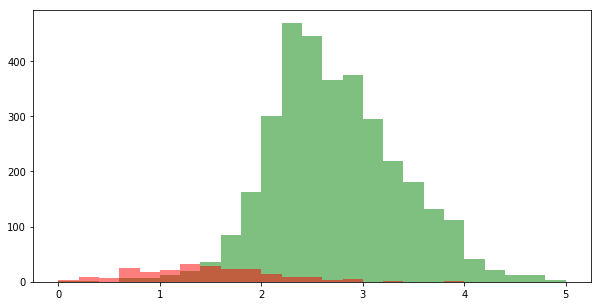

In [10]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
#SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']<1.4) & (SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['zwarn_cas']==0) & (SV_depth_catalog['zwarn_cas_2']==0)]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
plt.figure(figsize=(10,5))
plt.hist(np.log10(good_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='g',label='Good')
plt.hist(np.log10(bad_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='r',label='Bad')
#search = np.where(SV_depth_catalog['dz_subset']>=0.0033)
#plt.hist(np.log10(SV_depth_catalog['DELTACHI2_cas'][search[0]]),range=(0,5),bins=25,alpha=0.5,color='orange',label='No repeatable')
print(len(SV_depth_catalog))
print(len(good_catalog))
print(len(search[0]))
search2 = np.where(bad_catalog['dz_subset']>=0.0033)
print(len(search2[0]))
search3 = np.where(good_catalog['dz_subset']>=0.0033)
print(len(search3[0]))
plt.axvline(np.log10(20),ls='--',color='black')
plt.legend()
plt.xlabel('log10 Deltachi2')
plt.yscale('log')

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(good_catalog['Z'],np.log10(good_catalog['DELTACHI2_cas']),color='g',s=3,alpha=0.5,label='Good')
plt.scatter(bad_catalog['Z'],np.log10(bad_catalog['DELTACHI2_cas']),color='r',s=3,alpha=1,label='Bad')
plt.scatter(bad_1['Z'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=3,alpha=1,label='Bad 1')
#plt.scatter(SV_depth_catalog['Z'][search[0]],np.log10(SV_depth_catalog['DELTACHI2_cas'][search[0]]),color='orange',alpha=0.5,s=30,zorder=0,label='dz/(1+z)>0.0033 in two subsets')

plt.legend()
plt.xlim(-0.05,2)
plt.ylim(0,5)

plt.axvline(1.4)
plt.axhline(np.log10(20))
plt.xlabel('Redshift')
plt.ylabel('log10 DELTACHI2')

IndexError: index 3573 is out of bounds for axis 0 with size 3561

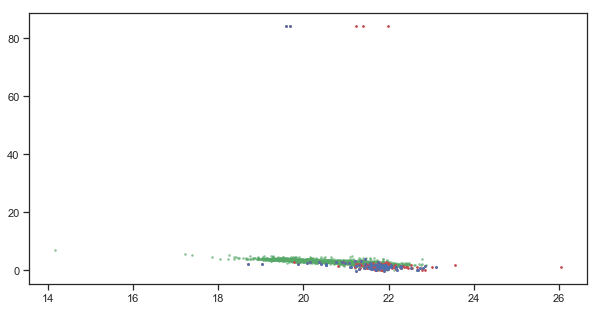

In [142]:
plt.figure(figsize=(10,5))
plt.scatter(flux_to_mag(good_catalog)['z'],np.log10(good_catalog['DELTACHI2_cas']),color='g',s=3,alpha=0.5,label='Good')
plt.scatter(flux_to_mag(bad_catalog)['z'],np.log10(bad_catalog['DELTACHI2_cas']),color='r',s=3,alpha=1,label='Bad')
plt.scatter(flux_to_mag(bad_1)['z'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=3,alpha=1,label='Bad 1')
plt.scatter(flux_to_mag(SV_depth_catalog[search[0]])['z'],np.log10(SV_depth_catalog['DELTACHI2_cas'][search[0]]),color='orange',s=30,alpha=0.5,label='dz/(1+z)>0.0033 in two subsets',zorder=0)


plt.legend()
plt.xlim(18,23)
plt.ylim(0,5)

plt.axvline(1.4)
plt.axhline(np.log10(20))
plt.xlabel('zmag')
plt.ylabel('log10 DELTACHI2')

Text(0.5, 1.0, 'LRG 80605 & 80609')

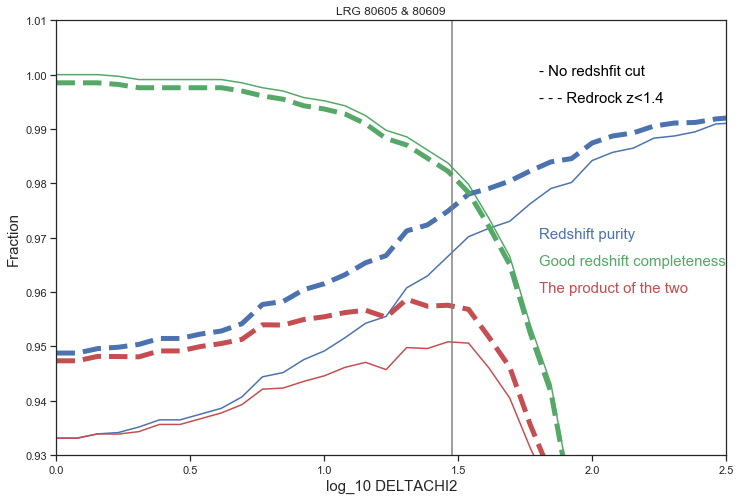

In [137]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
total_good_number = len(good_catalog)

log_deltach2_bin = my_wise_ut.my_bin_maker(0.0,3,40)
plt.figure(figsize=(12,8))
bins, fraction,good_fraction = deltachi2_limit_maximize(SV_depth_catalog,log_deltach2_bin,total_good_number)
plt.subplot(1,1,1)
plt.plot(bins,fraction,color='b')
plt.plot(bins,good_fraction,color='g')
plt.plot(bins,np.array(good_fraction)*fraction,color='r')
plt.ylim(0.93,1.01)
plt.xlim(0.0,2.5)
#plt.axhline(0.98,ls='--')

SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[SV_depth_catalog['Z']<1.4]
bins, fraction,good_fraction = deltachi2_limit_maximize(SV_depth_catalog,log_deltach2_bin,total_good_number)
plt.plot(bins,fraction,color='b',ls='--',lw=5)
plt.plot(bins,good_fraction,color='g',ls='--',lw=5)
plt.plot(bins,np.array(good_fraction)*fraction,color='r',ls='--',lw=5)

plt.text(1.8,1.0,'- No redshfit cut',fontsize=15,color='black')
plt.text(1.8,0.995,'- - - Redrock z<1.4',fontsize=15,color='black')
plt.text(1.8,0.97,'Redshift purity',fontsize=15,color='b')
plt.text(1.8,0.965,'Good redshift completeness',fontsize=15,color='g')
plt.text(1.8,0.96,'The product of the two',fontsize=15,color='r')
plt.xlabel('log_10 DELTACHI2',fontsize=15)
plt.axvline(np.log10(30),color='grey')
plt.ylabel('Fraction',fontsize=15)
plt.title('LRG 80605 & 80609')

Text(0, 0.5, 'DELTACHI2_3x4_cascades')

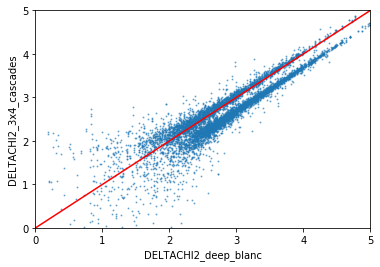

In [126]:
#SV_depth_catalog = pf.getdata(dir+dataname,1)
#SV_depth_catalog = SV_depth_catalog[SV_depth_catalog['TILEID']==80609]
plt.scatter(np.log10(SV_depth_catalog['DELTACHI2']),np.log10(SV_depth_catalog['DELTACHI2_cas']),s=1,alpha=0.5)
plt.xlim(0,5)
plt.ylim(0,5)
plt.plot(np.arange(0,10),np.arange(0,10),color='r')
plt.xlabel('DELTACHI2_deep_blanc')
plt.ylabel('DELTACHI2_3x4_cascades')

In [147]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog
total = (len(SV_depth_catalog))
print(len(SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['DELTACHI2_cas']<60) & (SV_depth_catalog['Z']<1.4)])/total)

0.04507160909856782


In [148]:
print(len(SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['DELTACHI2_cas']<40) & (SV_depth_catalog['Z']<1.4)])/total)

0.020780679584386407


In [150]:
print(len(SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>60) & (SV_depth_catalog['DELTACHI2_cas']<80) & (SV_depth_catalog['Z']<1.4)])/total)

0.02597584948048301


# Exploring single exposure 

In [147]:
dataname = 'LRG_80605_80609_subset_merge_all_exposure.fits'
data = pf.getdata(dir+dataname,1)
data = data[(data['EFFTIME_DARK']>750) & (data['EFFTIME_DARK']<1250) & (data['ZWARN_cas']==0)]
dz_sub = abs(data['Z']-data['Z_sub'])/(1+data['Z'])
good, bad, bad1, bad2 = good_robust_redrock_redshift(data)
#data.names

1950
299


Text(0.5, 0, 'log Deltachi10 SV exposure')

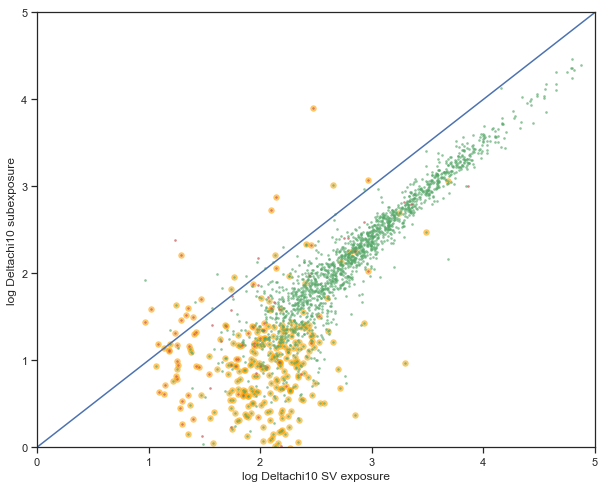

In [148]:
#dz_sub = abs(good['Z']-good['Z_sub'])/(1+good['Z'])
plt.figure(figsize=(10,8))
search = np.where(dz_sub>0.0033)
print(len(dz_sub))
print(len(search[0]))
plt.scatter(np.log10(good['DELTACHI2_cas']),np.log10(good['DELTACHI2_sub']),s=3,alpha=0.5,color='g')
plt.scatter(np.log10(data['DELTACHI2_cas'][search[0]]),np.log10(data['DELTACHI2_sub'][search[0]]),s=30,alpha=0.5,color='orange',zorder=0)
plt.scatter(np.log10(bad['DELTACHI2_cas']),np.log10(bad['DELTACHI2_sub']),s=3,alpha=0.5,color='r')

plt.plot(np.arange(0,10),np.arange(0,10))
plt.ylim(0.,5)
plt.xlim(0.,5)
plt.ylabel('log Deltachi10 subexposure')
plt.xlabel('log Deltachi10 SV exposure')

1950
299


(array([  0.,   0.,  11.,  37.,  86., 127.,  28.,   6.,   3.,   1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

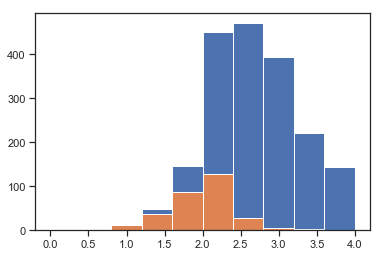

In [149]:
plt.hist(np.log10(data['DELTACHI2_cas']),bins=10,range=(0,4))
search = np.where(dz_sub>0.0033)
print(len(data))
print(len(search[0]))
plt.hist(np.log10(data['DELTACHI2_cas'][search[0]]),bins=10,range=(0,4))

(0, 6)

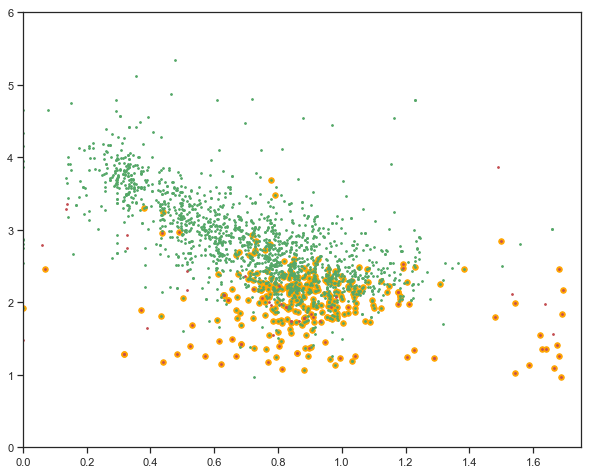

In [150]:
plt.figure(figsize=(10,8))
plt.scatter(good['Z'],np.log10(good['DELTACHI2_cas']),s=3,color='g')
plt.scatter(data['Z'][search[0]],np.log10(data['DELTACHI2_cas'][search[0]]),s=30,color='orange',zorder=0)
plt.scatter(bad['Z'],np.log10(bad['DELTACHI2_cas']),s=3,color='r')

plt.xlim(0,1.75)
plt.ylim(0,6)

Text(0, 0.5, 'log10 DELTACHI2')

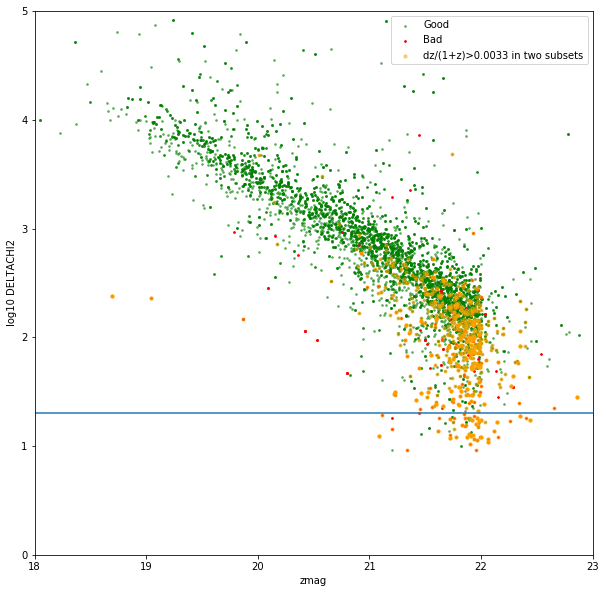

In [93]:
plt.figure(figsize=(10,10))
plt.scatter(flux_to_mag(good)['z'],np.log10(good['DELTACHI2_cas']),color='g',s=3,alpha=0.5,label='Good')
plt.scatter(flux_to_mag(bad)['z'],np.log10(bad['DELTACHI2_cas']),color='r',s=3,alpha=1,label='Bad')
#plt.scatter(flux_to_mag(bad_1)['z'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=3,alpha=1,label='Bad 1')
plt.scatter(flux_to_mag(data[search[0]])['z'],np.log10(data['DELTACHI2_cas'][search[0]]),color='orange',s=10,alpha=0.5,label='dz/(1+z)>0.0033 in two subsets')


plt.legend()
plt.xlim(18,23)
plt.ylim(0,5)

plt.axvline(1.4)
plt.axhline(np.log10(20))
plt.xlabel('zmag')
plt.ylabel('log10 DELTACHI2')

In [220]:
dataname = 'LRG_SV_all_with_short_exposures.fits'
data = pf.getdata(dir+dataname,1)
#data.names
data = data[(data['EFFTIME_DARK_all']>3000) & (data['EFFTIME_DARK_all']<5000) & (data['ZWARN_all']==0) & 
#            (data['DELTACHI2_all']>100) & 
            (data['EFFTIME_DARK_sub']>750) & (data['EFFTIME_DARK_sub']<1250)]
dz_sub = abs(data['Z_all']-data['Z_sub'])/(1+data['Z_all'])
search = np.where(dz_sub>0.0033)
print(len(dz_sub))
print(len(search[0])*1.0/len(dz_sub))

13852
0.10157377995957262


10521
119


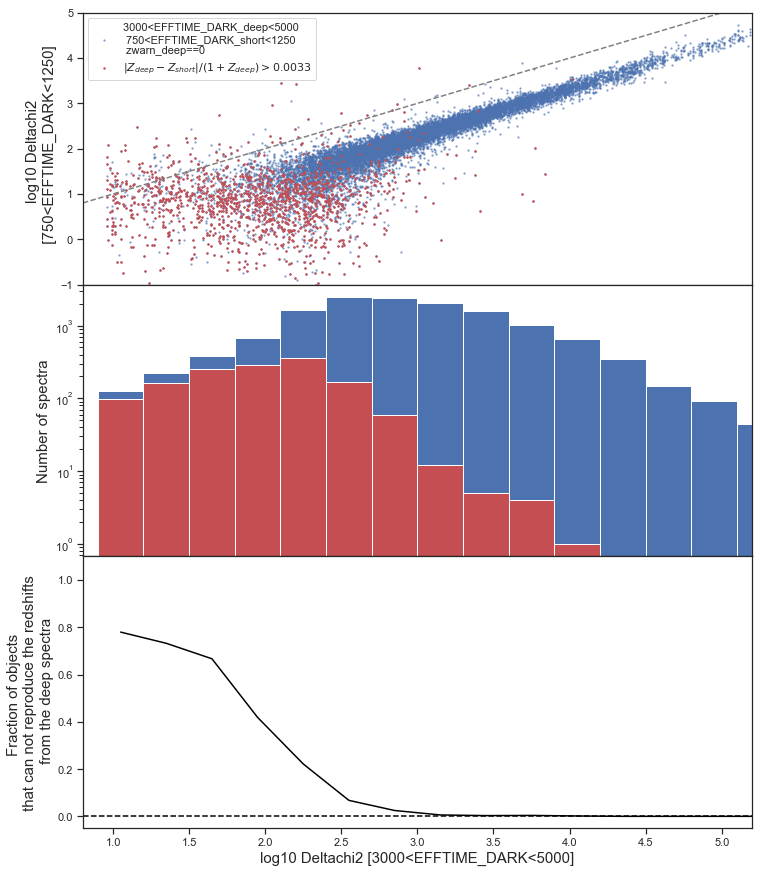

In [221]:

plt.figure(figsize=(12,15))
plt.subplots_adjust(hspace=0.0)
plt.subplot(3,1,1)
plt.scatter(np.log10(data['DELTACHI2_all']),np.log10(data['DELTACHI2_sub']),s=2,alpha=0.5,label='3000<EFFTIME_DARK_deep<5000 \n 750<EFFTIME_DARK_short<1250 \n zwarn_deep==0')
plt.scatter(np.log10(data['DELTACHI2_all'][search[0]]),np.log10(data['DELTACHI2_sub'][search[0]]),s=2,color='r',alpha=1,label='$|Z_{deep}-Z_{short}|/(1+Z_{deep})>0.0033$')
search2 = np.where(data['DELTACHI2_sub']>40)
new_dz_sub = dz_sub[search2[0]]
print(len(new_dz_sub))
print(len(np.where(new_dz_sub>0.0033)[0]))
plt.legend()
plt.plot(np.arange(0,10),np.arange(0,10),ls='--',color='grey')
plt.ylabel('log10 Deltachi2 \n  [750<EFFTIME_DARK<1250]',fontsize=15)
plt.xlim(0.8,5.2)
plt.ylim(-1,5)


plt.subplot(3,1,2)
plt.ylabel('Number of spectra',fontsize=15)
plt.hist(np.log10(data['DELTACHI2_all']),bins=20,range=(0,6),color='b')
plt.hist(np.log10(data['DELTACHI2_all'][search[0]]),bins=20,range=(0,6),color='r')
plt.yscale('log')
plt.xlim(0.8,5.2)
plt.subplot(3,1,3)
all_count = np.histogram(np.log10(data['DELTACHI2_all']),bins=20,range=(0,6))
bad_count = np.histogram(np.log10(data['DELTACHI2_all'][search[0]]),bins=20,range=(0,6))

plt.plot(all_count[1][0:-1]+0.5*(all_count[1][1]-all_count[1][0]),bad_count[0]/all_count[0],color='black')
plt.xlim(0.8,5.2)
plt.ylim(-0.05,1.1)
plt.ylabel('Fraction of objects \n that can not reproduce the redshifts \n from the deep spectra',fontsize=15)
plt.xlabel('log10 Deltachi2 [3000<EFFTIME_DARK<5000]',fontsize=15)
plt.axhline(0.0,ls='--',color='black')

In [169]:
all_count

(array([   0,    0,    0,   30,  128,  192,  311,  470,  878, 1754, 2138,
        1903, 1688, 1423, 1036,  692,  421,  293,  136,   78]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]))

(0.5, 5)

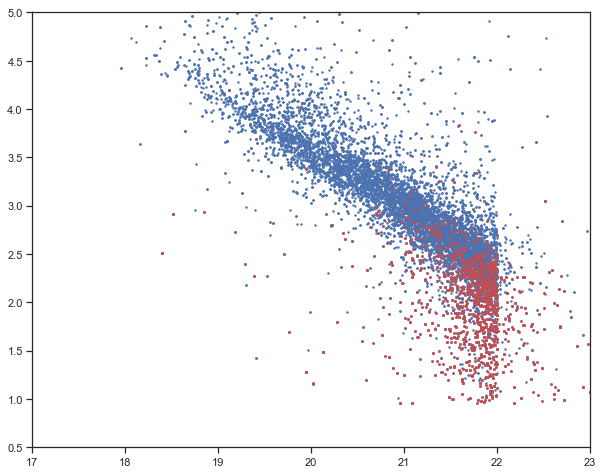

In [164]:
plt.figure(figsize=(10,8))
plt.scatter(flux_to_mag(data)['z'],np.log10(data['DELTACHI2_all']),s=2)
plt.scatter(flux_to_mag(data[search[0]])['z'],np.log10(data['DELTACHI2_all'][search[0]]),s=3,color='r')

plt.plot(np.arange(0,5),np.arange(0,5))
plt.xlim(17,23)
plt.ylim(0.5,5)

(0.5, 5)

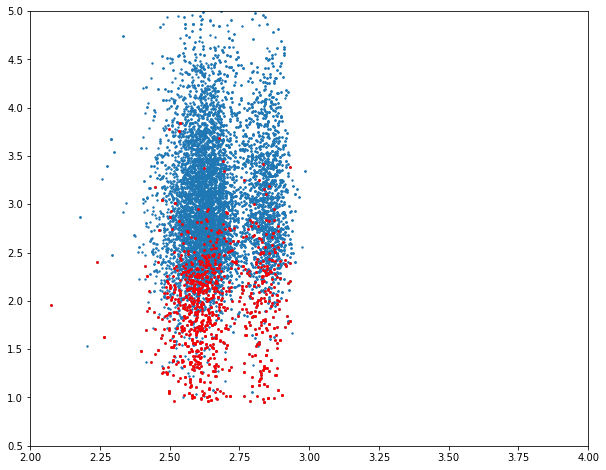

In [70]:
plt.figure(figsize=(10,8))
plt.scatter(np.log10(data['TSNR2_LRG_all']),np.log10(data['DELTACHI2_all']),s=2)
plt.scatter(np.log10(data['TSNR2_LRG_all'][search[0]]),np.log10(data['DELTACHI2_all'][search[0]]),s=3,color='r')

#plt.plot(np.arange(0,5),np.arange(0,5))
plt.xlim(2,4)
plt.ylim(0.5,5)

In [67]:
data['TSNR2_LRG_all']

array([394.87497, 376.24832, 560.23267, ..., 314.40436, 321.0934 ,
       321.0934 ], dtype=float32)

In [77]:
b = ['all']
b= b*10
print(b)

['all', 'all', 'all', 'all', 'all', 'all', 'all', 'all', 'all', 'all']


In [80]:
import seaborn as sns
sns.set_theme(style="ticks")

d = {'DELTACHI2_all':np.log10(data['DELTACHI2_all']),'DELTACHI2_sub':np.log10(data['DELTACHI2_sub']),'subset':['all']*len(data['DELTACHI2_sub'])}
df = pd.DataFrame(data=d)
d = {'DELTACHI2_all':np.log10(data['DELTACHI2_all'][search[0]]),'DELTACHI2_sub':np.log10(data['DELTACHI2_sub'][search[0]]),'subset':['Non repeatable redshifts']*len(data['DELTACHI2_sub'][search[0]])}
df2 = pd.DataFrame(data=d)

d_all = pd.concat([df, df2])

#d_all

,DELTACHI2_all,DELTACHI2_sub,subset
0,3.393379,3.258089,all
1,3.388592,2.850408,all
2,5.290200,4.827767,all
3,2.521547,2.031066,all
4,2.705871,2.467758,all
...,...,...,...
1009,2.293958,0.649686,Non repeatable redshifts
1010,3.773999,2.019239,Non repeatable redshifts
1011,2.440648,0.911483,Non repeatable redshifts
1012,1.874905,1.060680,Non repeatable redshifts


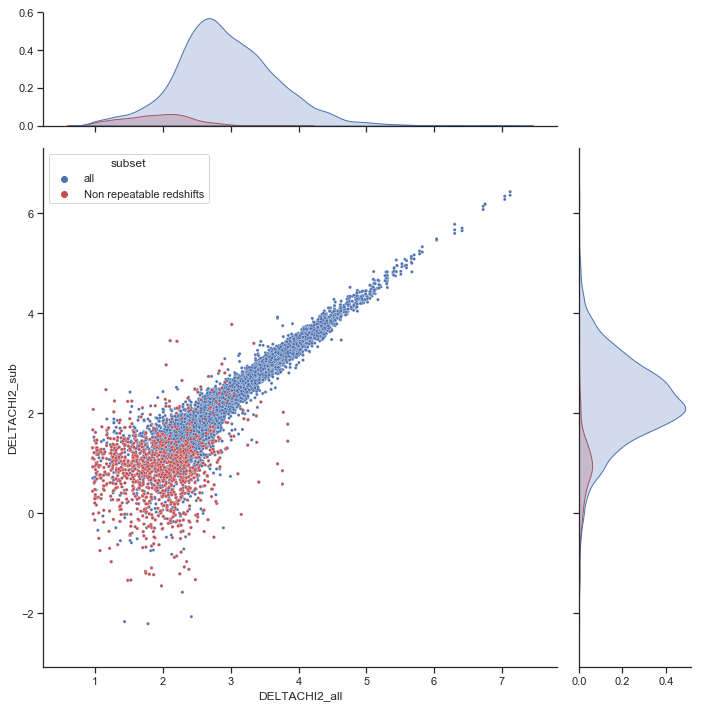

In [105]:
g = sns.jointplot(
    data=d_all,
    x="DELTACHI2_all", y="DELTACHI2_sub", hue="subset",
    kind="scatter",height=10, ratio=4, marginal_ticks=True, palette=['b','r'],s=10
)


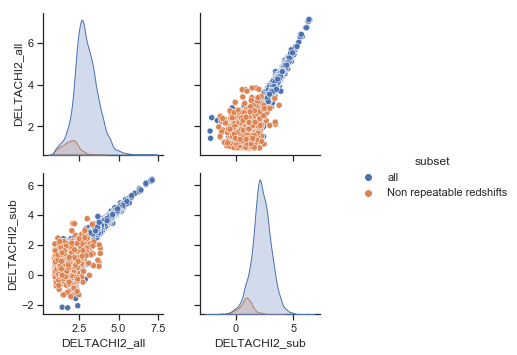

In [82]:
sns.pairplot(d_all, hue="subset")

In [12]:
dataname ='LRG_80605_80609_subset_merge.fits'
SV_depth_catalog = pf.getdata(dir+dataname,1)
z = flux_to_mag(SV_depth_catalog)['z']

0.2600393147992137